Imagine you are a recent hire at the bank. Your manager fills you in about a discussion among executives from Marketing and Wealth Management regarding the hypothesis that clients with more kinds of products at the bank keep more deposit dollars here.  Your manager asks you to investigate this issue and prepare a report that can go to the executives from both departments, as well as to the Chief Deposit Officer.  For this purpose, it is sufficient to consider three broad product categories: deposits (checking and savings), loans (assets borrowed from the bank), and wealth management (stocks and bonds).

The initial exercises below promote familiarity with the client and bank account data needed to address this hypothesis.  The final question asks you to make an assessment on the matter.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

%matplotlib inline

acctdf = pd.read_csv("data/AccountTable.csv")
clientdf = pd.read_csv('data/ClientTable.csv')
bridgedf = pd.read_csv('data/ClientAcctFact.csv')

display(acctdf.head())
display(clientdf.head())
display(bridgedf.head())

print("Account table dimensions: ", acctdf.shape)
print("Client table dimensions: ", clientdf.shape)
print('Client-account bridge table dimensions: ', bridgedf.shape)

,AccountBalance,AccountID,AccountStatus,AccountType
0,25127.38,44363,open,D
1,25662.58,36801,open,D
2,3149.79,38963,open,D
3,870489.00,53464,open,L
4,714025.00,30787,open,L


,ClientID,Gender,Name,Region
0,1353110,M,Zeus Odetta,NE
1,168163,M,Eliza Aye,SW
2,7170,M,Claude Janissa,SE
3,747320,F,Coreena Renada,NE
4,754670,M,Laurance Kalishia,NE


,AccountID,ClientID
0,44363,1353110
1,36801,1353110
2,38963,1353110
3,53464,1353110
4,30787,1353110


Account table dimensions:  (4139, 4)
Client table dimensions:  (902, 4)
Client-account bridge table dimensions:  (4139, 2)


# Client Table Questions

### How many clients are in the bank?

In [2]:
print('There are total '+str(clientdf['ClientID'].nunique())+' clients in the bank')

There are total 902 clients in the bank


### How many clients are in each region?

In [3]:
clientdf[['ClientID','Region']].groupby('Region').count()

,ClientID
Region,
NE,421
NW,115
SE,195
SW,171


### Create a bar plot of gender frequency

In [4]:
y=clientdf['Gender'].value_counts().tolist()

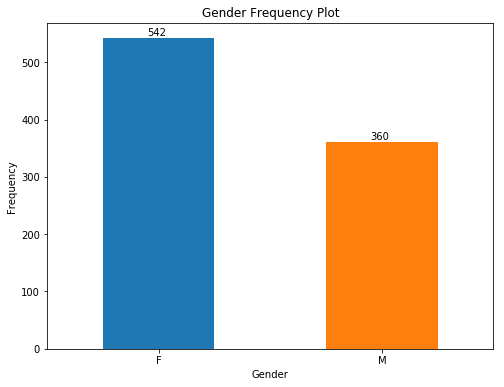

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_ylabel('Frequency')
ax.set_xlabel('Gender')
ax.set_title('Gender Frequency Plot')

clientdf['Gender'].value_counts().plot(ax=ax, kind='bar')
plt.xticks(rotation=0)

for i, v in enumerate(y):
    plt.text(i-0.05, v+5, str(v))
plt.show()

# Account Table Questions

### What percentage of all accounts are {open, closed}?

In [6]:
perc=acctdf['AccountStatus'].value_counts(normalize=True)['open']+acctdf['AccountStatus'].value_counts(normalize=True)['closed']
print('Percentage of {open,closed} accounts are '+"{0:0.2%}".format(perc))

Percentage of {open,closed} accounts are 94.61%


### What percentage of D accounts are closed?

In [7]:
acctdf_D=acctdf.loc[acctdf['AccountType'] == 'D']
perc_D=acctdf_D['AccountStatus'].value_counts(normalize=True)['closed']
print('Percentage of D accounts are closed is '+"{0:0.2%}".format(perc_D))

Percentage of D accounts are closed is 10.64%


# Combined Client and Account table

### Merge the Client and Account tables together

In [8]:
acctdf_temp=pd.merge(left=acctdf,right=bridgedf,how='inner',on='AccountID')
comb = pd.merge(left=clientdf,right=acctdf_temp,how='left',on='ClientID')

### Create a new field in the merged table called 'ClientType' that tells you the type of open accounts that each client has. For example, if a client currently has a D, L and W account, the ClientType would be 'DLW'. If a client only has an open D and L account then the ClientType would be 'DL'.

In [9]:
def unique_letter(x):
    return ''.join(sorted(''.join(set(x))))

temp1=comb[['ClientID','AccountType']].loc[comb['AccountStatus']=='open'].groupby('ClientID').sum()
temp2=temp1.loc[temp1['AccountType']!=0].copy()
temp2['ClientType']=temp2['AccountType'].apply(unique_letter)
comb=comb.merge(temp2.drop(columns=['AccountType']),on='ClientID',how='left')
comb.head(10)

,ClientID,Gender,Name,Region,AccountBalance,AccountID,AccountStatus,AccountType,ClientType
0,1353110,M,Zeus Odetta,NE,25127.38,44363.0,open,D,DLW
1,1353110,M,Zeus Odetta,NE,25662.58,36801.0,open,D,DLW
2,1353110,M,Zeus Odetta,NE,3149.79,38963.0,open,D,DLW
3,1353110,M,Zeus Odetta,NE,870489.00,53464.0,open,L,DLW
4,1353110,M,Zeus Odetta,NE,714025.00,30787.0,open,L,DLW
5,1353110,M,Zeus Odetta,NE,788544.00,90141.0,open,W,DLW
6,1353110,M,Zeus Odetta,NE,1920996.00,9976.0,open,W,DLW
7,1353110,M,Zeus Odetta,NE,451584.00,25118.0,open,W,DLW
8,1353110,M,Zeus Odetta,NE,708964.00,97251.0,closed,W,DLW
9,1353110,M,Zeus Odetta,NE,2471184.00,30337.0,open,W,DLW


### How many different client types are there?

In [10]:
diff_type=comb['ClientType'].nunique()
print('There are '+str(diff_type)+' different client types')

There are 7 different client types


### How many clients have open accounts of all three product types (D, L, and W)?  With what probability do you think your answer is correct?  Please justify.

In [11]:
num_threetypes=comb['ClientID'].loc[comb['ClientType']=='DLW'].nunique()
print('There are '+str(num_threetypes)+' clients have all three open accounts')
print('I am confident this is the correct figure, separately validate from excel')

There are 84 clients have all three open accounts
I am confident this is the correct figure, separately validate from excel


### What is the average open W account balance for clients that have at least two open L accounts?  With what probability do you think your answer is correct?  Please justify.

In [12]:
temp3=comb.loc[(comb['AccountStatus']=='open')].groupby(['ClientID']).filter(lambda x:x.loc[x['AccountType']=='L']['AccountStatus'].count()>=2)
avg_open_w=temp3.loc[temp3['AccountType']=='W'].groupby(['ClientID'])['AccountBalance'].mean().mean()
print('Average open W account balance for clients that have at least two open L accounts is '+str(avg_open_w))
print('I am confident this is the correct figure, separately validate from excel')

Average open W account balance for clients that have at least two open L accounts is 1143544.5332821303
I am confident this is the correct figure, separately validate from excel


# Business Question

- We hypothesize that clients with more product types also have more **deposit** dollars with us.  Please provide evidence either for or against this hypothesis.  
- How confident are you in your answer, and why?

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison,pairwise_tukeyhsd
import seaborn as sns

##### We can run a one-way ANOVA analysis to check if the Hypothesis is true or not. 
- Categories are cliensts with 1,2,3 OPEN accounts (we exclude clients with no account balance, closed and unknow accounts)
- Response variable is the sum of account balances

- Step 1: Create DataFrame for Anova Analysis
- Step 2: a the mean and standard diviation by number of accounts
- Step 3: ANOVA Result Analysis
- Step 4: Check ANOVA assumption
       -- Normality: The distribution of the response variable follows a normal distribution
       -- The population variances are equal across responses for the group levels
- Step 5: Conclusion

##### Step 1 - Create Dataframe

In [15]:
aggregations = {
    'AccountBalance':'sum',
    'AccountType': 'nunique'}

df=comb.loc[(comb['AccountStatus']=='open')].groupby(['ClientID']).agg(aggregations)
df.rename(columns={'AccountType':'ProductTypes'}, inplace=True)
df.head(5)

,AccountBalance,ProductTypes
ClientID,,
784,5611785.00,2
1291,835396.00,1
7138,7338156.99,3
7170,90090.23,1
7475,3204362.31,2


##### Step 2 - Visualization

Mean and Standardiviation in Thousands 000 



AccountBalance             
                       mean          std
ProductTypes                            
1                616.025075   957.325429
2               2504.958405  1633.779289
3               7447.493138  2810.936447

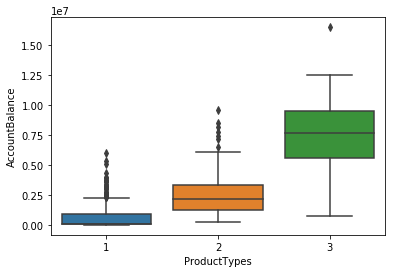

In [16]:
ax = sns.boxplot(x="ProductTypes", y="AccountBalance", data=df)
aggregations = {
    'AccountBalance':['mean','std']}
print('Mean and Standardiviation in Thousands 000','\n')
df.groupby('ProductTypes').agg(aggregations)/1000

As observe above the mean and std are quite different between groups.
The AccountBalance is higher for client with larger ProductTypes.

##### Step 3 - ANOVA Result Analysis

In [27]:
# One-Way ANOVA

In [28]:
results = ols('AccountBalance ~ C(ProductTypes)', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         AccountBalance   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     774.2
Date:                Sat, 25 Apr 2020   Prob (F-statistic):          1.12e-185
Time:                        20:25:53   Log-Likelihood:                -12190.
No. Observations:                 780   AIC:                         2.439e+04
Df Residuals:                     777   BIC:                         2.440e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              6.16e+05 

##### As observe above the Prob (F-statistic) is close to zero, this is an indicator to:
- It is statistically significant to say that the account balance of cliensts with 1,2,3 ProductTypes are different
- We need to further run a Post-hoc test to find out how are the differences between ProductTypes

In [21]:
# Post-hoc Testing with Tukey’s HSD

In [22]:
mc = MultiComparison(data=df['AccountBalance'],groups=df['ProductTypes'])
mc_results = mc.tukeyhsd()
print(mc_results)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj    lower        upper     reject
-----------------------------------------------------------------
     1      2   1888933.33 0.001 1611442.0109 2166424.6491   True
     1      3 6831468.0631 0.001  6416900.405 7246035.7212   True
     2      3 4942534.7331 0.001 4500834.0043  5384235.462   True
-----------------------------------------------------------------


As observe above:
- Clients with 2 or 3 ProductTypes have a significant higher account balance than clients with 1 ProductTypes
- Clients with 2 ProductTypes have a significant higher account balance than clients with 1 ProductTypes

##### Step 4 - Conclusion
```
We agree with the hypothesis from management, that is clients with more kinds of products at the bank keep more deposit dollars here.

And our conclusion is correct with 99.9% probability

```